In [1]:
%load_ext autoreload
%autoreload 2

## Обучение рекомендательной системы для симулированных пользователей

Одна из задач симулятора - делать рекомендации, не используя реальные исторические данные. У вас нет исторических данных, но доступен симулятор, генерирующий отклики пользователей на рекомендации, который поможет получить данные в интерактивном режиме.


### Пользователи
3251 синтетических пользователей

### Товары
3327 товаров для рекомендаций

В этом задании вам доступные фичи товаров (_./data/task_3_data/item_features.parquet_)

### Задача
Построить рекомендательную систему, которая даст наибольшее количество кликов

### Доступные данные
Пользователи будут реагировать на ваши рекомендации в интерактивном режиме. Вы получаете список пользователей, для каждого из которых нужно подготовить по 20 рекомендаций. Симулятор генерирует отклики на рекомендации, которые вы можете использовать для обучения рекомендательной системы.

## Симулятор
Детальную информацию о симуляторе смотри в ноутбуке к заданию 1.

## Импорты и настройки

In [1]:
import os
from os.path import join
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [2]:
import time
import tqdm

import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql import SparkSession

from replay.data_preparator import Indexer
from replay.models import UCB
from replay.session_handler import State
from surprise import SVD, Dataset, Reader, SVDpp, KNNBaseline, SlopeOne, NMF

from simulator.modules import Simulator, RealDataGenerator

from helpers.task_3 import TaskThreeResponse
from helpers.utils import plot_metric, calc_metric


# укажите путь к tmp-папке spark и директории с чекпоинтами симулятора.
SPARK_LOCAL_DIR = './tmp/task_3'
CHECKPOINTS_DIR = './tmp/task_3_checkpoints'

In [3]:
NUM_THREADS = 4
spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()
State(spark)
spark.sparkContext.setLogLevel("ERROR");

22/12/03 11:37:19 WARN Utils: Your hostname, cl1nr5sb14mq6gk2g9m8-ybuc resolves to a loopback address: 127.0.1.1; using 10.129.0.36 instead (on interface eth0)
22/12/03 11:37:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/03 11:37:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/03 11:37:20 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/12/03 11:37:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/03 11:37:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/1

In [4]:
NUM_ITEMS = 3327
NUM_USERS = 3251
# число рекомендаций, генерируемых рекомендательной системой на пользователя на одной итерации
K = 20
# количество итераций
NUM_ITER = 50
SEED = 1234

In [5]:
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

## Исходные данные

В нашем распоряжении есть id пользователей и товаров.

In [6]:
syn_users = spark.read.parquet('data/task_3_data/user_idx.parquet')
available_items = spark.read.parquet('data/task_3_data/item_idx.parquet')
syn_users.show(2)

+----------+
|   user_id|
+----------+
|synth_2438|
|synth_2439|
+----------+
only showing top 2 rows



In [7]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=syn_users, items=available_items)
users = indexer.transform(syn_users)
users.cache()
users.count()

3251

In [8]:
items = indexer.transform(available_items)
items.cache()
items.count()

3327

In [9]:
users.show(2)

+--------+
|user_idx|
+--------+
|    1600|
|    1601|
+--------+
only showing top 2 rows



## Модель отклика

Модель отклика принимает датафрейм с колонками <user_idx, item_idx, relevance>, где relevance - оценка релевантности рекомендательной системы и возвращает датафрейм с обязательными колонками <user_idx, item_idx, relevance, response>, добавляя к исходным данным столбец с откликами (response). Если в датафрейме, поданном на вход в модель отклика, были признаки, они также будут возвращены.

In [10]:
task_3_model = TaskThreeResponse(spark)

Посмотрим на примере, как формируется отклик для пар:

In [11]:
task_3_model.transform(
    users.limit(1).crossJoin(items.limit(2)).withColumn("relevance", sf.lit(1.))
).select('item_idx', 'user_idx', 'relevance', 'response').show()

+--------+--------+---------+--------+
|item_idx|user_idx|relevance|response|
+--------+--------+---------+--------+
|       0|    1600|      1.0|       0|
|       1|    1600|      1.0|       0|
+--------+--------+---------+--------+



# Обучение модели в симуляторе

Перейдем непосредственно к циклу симуляции. Инициализируем симулятор и все нужные для симуляции модели. Обратите внимание, что если вы захотите перезапустить эксперимент, нужно будет выбрать другую папку для сохранения данных `data_dir` или удалить с диска результаты предыдущего эксперимента. Либо вы можете продолжить эксперимент с новой итерации (например, последней была выполнена 10 итерация, значит цикл нужно продолжить с 11-ой). 

Запустите ячейки ниже последовательно, чтобы начать новый эксперимент.

## Инциализируем компоненты симулятора

In [12]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

# передадим популяции пользователей и айтемов
item_generator.fit(items)
user_generator.fit(users)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: int]

In [13]:
user_generator.sample(0.01).show(2)

+--------+
|user_idx|
+--------+
|    1518|
|     731|
+--------+
only showing top 2 rows



In [14]:
!rm -r $CHECKPOINTS_DIR

In [15]:
sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR,
)

## Инициализация вашей рекомендательной модели

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
class SVDRL:
    def __init__(self):
        #self.model = SVDpp(n_factors=20, n_epochs=20)
        self.models = [(KNNBaseline(k=40), 0.5), (SVDpp(n_factors=20, n_epochs=20), 0.3), (SVD(), 0.2)]
        #self.model = NMF(n_factors=20, n_epochs=20)
        self.ucb = UCB(sample=True, seed=SEED)
        self.scaler = MinMaxScaler()
        
    def fit(self, log=None):
        self.ucb.fit(log)
        log = log.toPandas()
        reader = Reader(rating_scale=(0, 1))
        data = Dataset.load_from_df(log[["user_idx", "item_idx", "relevance"]], reader)
        trainset = data.build_full_trainset()
        for e in range(3):
            self.models[e][0].fit(trainset)
        #self.model.fit(trainset)
        
    def predict(self, log=None, k=None, users=None, items=None, filter_seen_items=None):
        result = []
        recs = self.ucb.predict(
            log=log,
            k=items.count(),
            users=users,
            items=items,
            filter_seen_items=False
        ).cache()
        recs = recs.toPandas().sort_values(by=['user_idx', 'item_idx'])
        recs['relevance'] = self.scaler.fit_transform(np.array(recs['relevance']).reshape(-1, 1)).reshape(-1)
        it_ = 0
        for u in sorted(users.toPandas()['user_idx']):
            buffer = []
            for i in sorted(items.toPandas()['item_idx']):
                score = sum([model[0].predict(u, i).est * model[1] for model in self.models]) + recs.iloc[it_]['relevance'] * 0.1
                it_ += 1
                buffer.append((u, i, score))
            buffer.sort(key=lambda x: -x[2])
            result.extend(buffer[:k])
        return spark.createDataFrame(pd.DataFrame(result, columns=['user_idx', 'item_idx', 'relevance']))

In [17]:
### YOUR CODE HERE: инициализация модели. Замените код бейзлайна на ваш код

#model = UCB(exploration_coef=0.1, sample=True, seed=SEED)
model = UCB(seed=SEED, sample=True)
# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

### Проверка формата рекомендаций моделью

In [18]:
### YOUR CODE HERE: получите K уникальных рекомендаций для 10 пользователей 
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)
###

# проверьте правильность формирования рекомендаций
assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert pred.groupBy('user_idx').agg(sf.countDistinct("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10
assert pred.groupBy('user_idx').agg(sf.count("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10

## Цикл симуляции

Модель UCB не является персонализированной, поэтому довольно плохо подходит для задачи предсказания для персонализированной модели отклика основанной на тематических интересах. Она дана вам в качестве бейзлайна. Надеемся, у вас получится подобрать более подходящую модель. 

UPD: TODO Аня

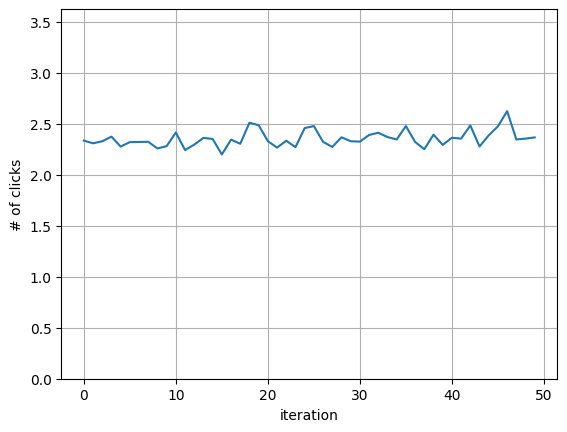

Iteration 49 finished in 4.654432773590088 sec.


In [19]:
metrics = []
for i in tqdm.auto.tqdm(range(NUM_ITER)):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(current_users)
    

    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    recs = model.predict(
       log=log,
       k=K,
       users=current_users.select("user_idx"),
       items=items,
       filter_seen_items=False
    ).cache()

    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )

    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=task_3_model,
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)
    
    # оцениваем качество
    metrics.append(calc_metric(true_resp))

    ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()
    
    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

In [26]:
# import pickle

# pickle.dump(model.models, open('task3_model.pkl', 'wb'))

TypeError: cannot pickle '_thread.RLock' object

In [27]:
#from replay.model_handler import save

In [31]:
#pickle.load(open('task3_model.pkl', 'rb'))

[(<surprise.prediction_algorithms.knns.KNNBaseline at 0x7f34e8d71310>, 0.5),
 (<surprise.prediction_algorithms.matrix_factorization.SVDpp at 0x7f34f4365700>,
  0.3),
 (<surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f34f4365460>,
  0.2)]

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 54244)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/venvs/hackenv/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/opt/venvs/hackenv/lib/python3.8/site-packages/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/opt/venvs/hackenv/lib/python3.8/site-packages/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(sel

## Финальный результат

In [20]:
import pickle
model_svd = SVDRL()
model_svd.models = pickle.load(open('task3_model.pkl', 'rb'))
model_svd.ucb = model

In [21]:
users_df = users.toPandas()
res_df = []
for i in tqdm.notebook.tqdm(range(0, users.count(), 100)):
    cur_users_df = users_df[i:i+100]
    recs = model_svd.predict(
        log=sim.log,
        k=K,
        users=spark.createDataFrame(cur_users_df),
        items=items,
        filter_seen_items=False
    ).toPandas()
    res_df.append(recs)

  0%|          | 0/33 [00:00<?, ?it/s]

In [23]:
pickle.dump(res_df, open('preds_task3.pkl', 'wb'))

In [24]:
recs = pd.concat(res_df)

In [26]:
recs = spark.createDataFrame(recs)

In [27]:
### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
# recs = model.predict(
#     log=sim.log,
#     k=K,
#     users=users,
#     items=items,
#     filter_seen_items=False
# ).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

Сохраните ноутбук, ячейки в котором выполнены последовательно. Результаты из ячейки ниже будут использоваться для оценки решения команды. Свою модель приложите к ноутбуку в виде py-файла и импортируйте модель из него для всех трех заданий. 

In [28]:
# получаем отклики на рекомендации
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=task_3_model
).cache()

# оцениваем качество
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

Среднее число купленных товаров на пользователя после обучения модели = 4.242079360196863


In [22]:
recs.unpersist()
true_resp.unpersist();